# Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

### Updated for Python 3.6 using Tensorflow 1.3.0 and Keras 2.09

In [4]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(0)
import numpy as np
#import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras import layers
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras #removed cPickle from here
#import pickle as cPickle
import pickle


In [5]:
# Load the dataset ...
#  You will need to seperately download or generate this file
# bzip2 -dk RML2016.10a_dict.dat.bz2
with open("/home/sl/Downloads/RML2016.10a_dict.dat",'rb') as f: # modified original python 2.7 code here
    Xd = pickle.load(f, encoding='latin1') 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5) # wrapped expression in int()
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx))) # python 3 needs a list to get len(yy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx))) # wrapped list to map operation

In [24]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [99]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
# update to keras 2 format
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(layers.Reshape([1]+in_shp, input_shape=in_shp))
model.add(layers.ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(layers.Conv2D(256, (1, 3), padding="valid", activation="relu", name="conv1", kernel_initializer="glorot_uniform",data_format="channels_first"))
model.add(layers.Dropout(dr))
model.add(layers.ZeroPadding2D((0, 2),data_format="channels_first"))
model.add(layers.Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer="glorot_uniform",data_format="channels_first"))
model.add(layers.Dropout(dr))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer="he_normal", name="dense1"))
model.add(layers.Dropout(dr))
model.add(layers.Dense( len(classes), kernel_initializer="he_normal", name="dense2" ))
model.add(layers.Activation('softmax'))
model.add(layers.Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_139 (Reshape)        (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_161 (ZeroPadd (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_196 (Dropout)        (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_162 (ZeroPadd (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_197 (Dropout)        (None, 80, 1, 132)        0         
__________

In [100]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [108]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
 - 21s - loss: 2.2406 - val_loss: 2.0979
Epoch 2/100
 - 16s - loss: 2.0305 - val_loss: 1.9109
Epoch 3/100
 - 16s - loss: 1.8957 - val_loss: 1.8041
Epoch 4/100
 - 16s - loss: 1.8054 - val_loss: 1.7043
Epoch 5/100
 - 16s - loss: 1.7128 - val_loss: 1.6512
Epoch 6/100
 - 16s - loss: 1.6593 - val_loss: 1.5745
Epoch 7/100
 - 16s - loss: 1.6132 - val_loss: 1.5147
Epoch 8/100
 - 16s - loss: 1.5679 - val_loss: 1.4609
Epoch 9/100
 - 16s - loss: 1.5271 - val_loss: 1.4146
Epoch 10/100
 - 16s - loss: 1.4892 - val_loss: 1.3930
Epoch 11/100
 - 16s - loss: 1.4669 - val_loss: 1.3741
Epoch 12/100
 - 16s - loss: 1.4454 - val_loss: 1.3452
Epoch 13/100
 - 16s - loss: 1.4317 - val_loss: 1.3396
Epoch 14/100
 - 16s - loss: 1.4190 - val_loss: 1.3375
Epoch 15/100
 - 16s - loss: 1.4087 - val_loss: 1.3255
Epoch 16/100
 - 16s - loss: 1.4012 - val_loss: 1.3530
Epoch 17/100
 - 16s - loss: 1.3943 - val_loss: 1.3121
Epoch 18/100
 - 16s - loss: 1.3955 - va

In [111]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

1.27321514954


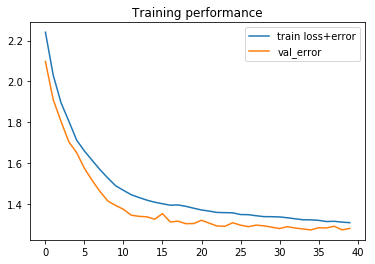

In [114]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [115]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

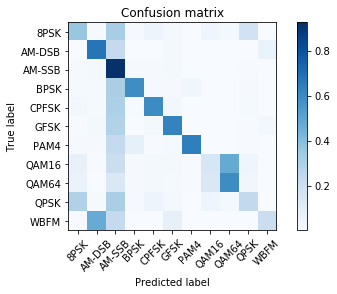

In [116]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.0946020128088
Overall Accuracy:  0.0922797456857
Overall Accuracy:  0.0942474674385
Overall Accuracy:  0.106640202093
Overall Accuracy:  0.13837739289
Overall Accuracy:  0.224631242225
Overall Accuracy:  0.338600036744
Overall Accuracy:  0.501832844575
Overall Accuracy:  0.609981515712
Overall Accuracy:  0.670718432511
Overall Accuracy:  0.711131386861
Overall Accuracy:  0.718284260269
Overall Accuracy:  0.737151248164
Overall Accuracy:  0.735559566787
Overall Accuracy:  0.734174932372
Overall Accuracy:  0.745719489982
Overall Accuracy:  0.728589534673
Overall Accuracy:  0.737220889463
Overall Accuracy:  0.731402714932
Overall Accuracy:  0.739513951395


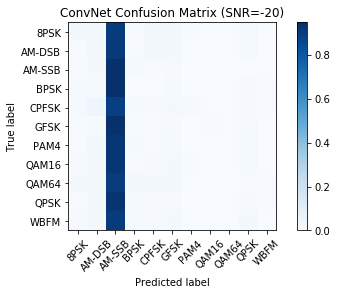

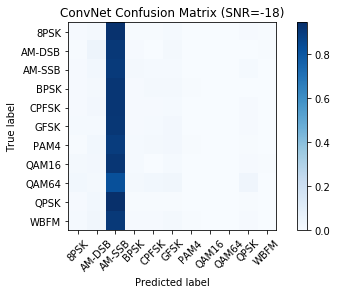

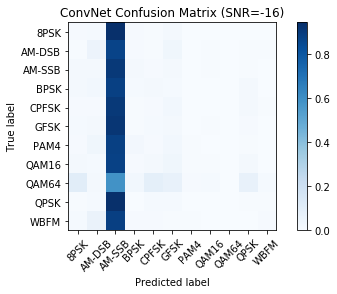

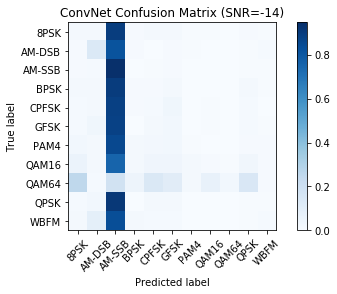

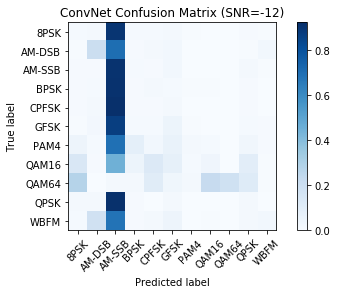

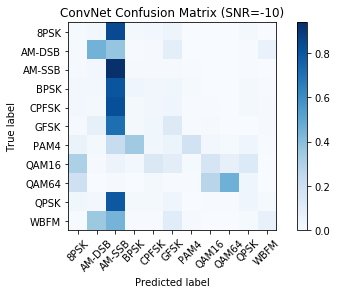

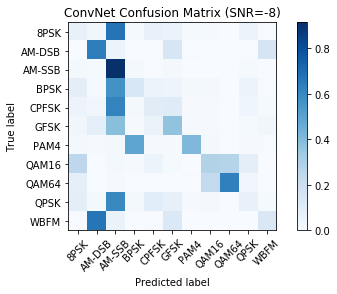

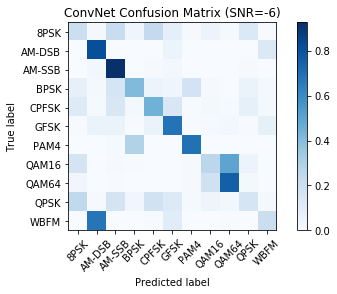

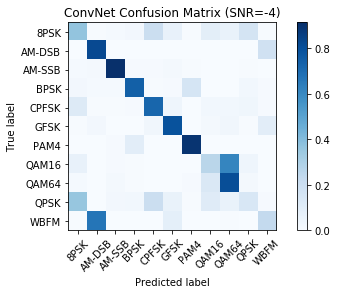

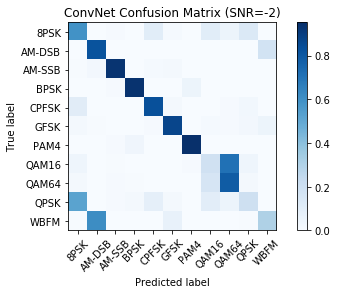

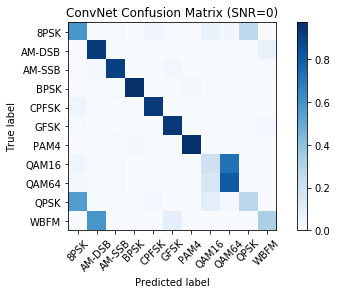

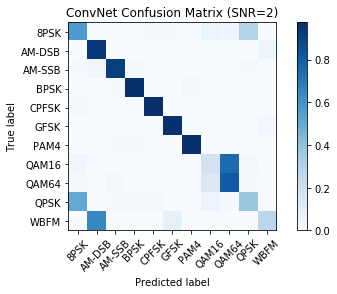

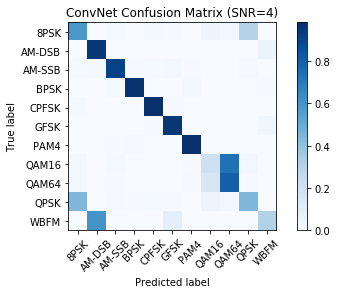

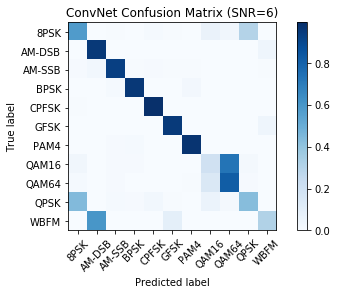

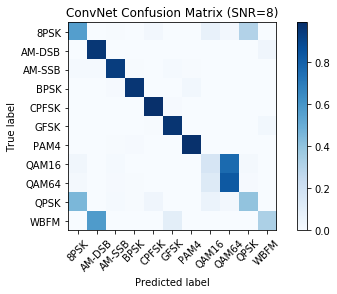

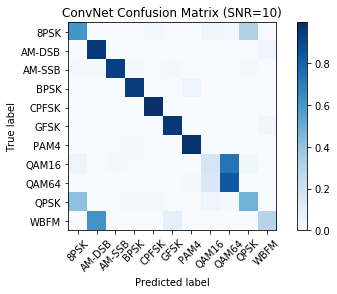

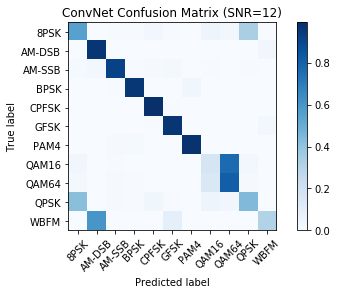

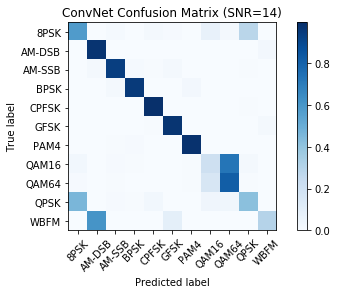

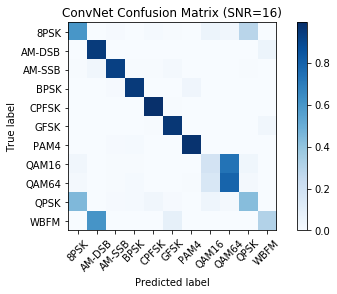

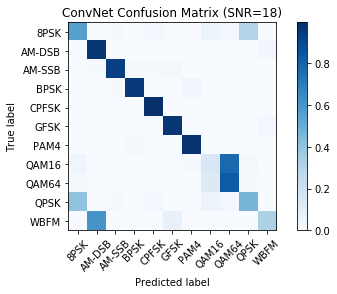

In [119]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)


In [124]:
# Save results to a pickle file for plotting later
print (acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.094602012808783165, -18: 0.092279745685740239, -16: 0.094247467438494936, -14: 0.10664020209310718, -12: 0.13837739288969919, -10: 0.22463124222498668, -8: 0.33860003674444239, -6: 0.50183284457478006, -4: 0.60998151571164505, -2: 0.67071843251088537, 0: 0.71113138686131383, 2: 0.71828426026899306, 4: 0.73715124816446398, 6: 0.73555956678700363, 8: 0.73417493237150588, 10: 0.74571948998178506, 12: 0.72858953467318488, 14: 0.73722088946300057, 16: 0.73140271493212672, 18: 0.73951395139513953}


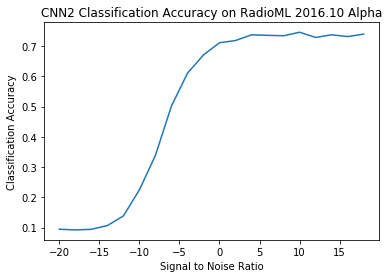

In [123]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")